<a href="https://colab.research.google.com/github/OscarBedford/MLCourse_Weekly_Exercises/blob/main/Exercise_11_10_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

10- analogous to task 5, but using same 3 models as in Task 6.

In [ ]:
%%capture
!pip install nilearn

In [ ]:
%%capture
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib

In [ ]:
%%capture
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_decomposition import PLSRegression as PLSR
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression as LR

In [ ]:
%%capture
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
%%capture
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], (1)) # we fix this at 1
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] # gives subject age on standard units after z-scoring

X, y = input_variables, output_variable              # We reinstate X, y at the start of the loop in order to reset their values

In [ ]:
# We predefine the models 
plsr    = PLSR(n_components=3,  scale=False)
cca     = CCA(n_components=2,  scale=False) 
pca    = PCA(n_components=3)
lr        = LR()

# We predefine the objects
scaler  = StandardScaler()
cv   = KFold(n_splits = 5, shuffle = True, random_state = 666)

# We create one pipeline for each model
pipe1 = make_pipeline(scaler, pca, plsr)
pipe2 = make_pipeline(scaler, pca, pca, lr)
pipe3 = make_pipeline(scaler, pca, cca)

In [ ]:
pipe2

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca-1', PCA(n_components=3)), ('pca-2', PCA(n_components=3)),
                ('linearregression', LinearRegression())])

In [ ]:
# We pre-allocate the variables where we will append the scores
weights1 = []
weights2 = []
weights3 = []

In [ ]:
for train_index, test_index in cv.split(X, y):
      X_train, y_train = X[train_index], y[train_index]
      X_test, y_test    = X[test_index],  y[test_index]

      plsr_model = pipe1.fit(X_train, y_train)     
      params1 = plsr_model.named_steps.plsregression.x_loadings_
      weights1.append(params1)

      pcr_model = pipe2.fit(X_train, y_train)     
      params2 = pcr_model.named_steps['pca-2'].components_
      weights2.append(params2)

      cca_model = pipe3.fit(X_train, y_train)     
      params3 = cca_model.named_steps.cca.x_loadings_
      weights3.append(params3)

/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(2) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(2) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(2) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/

We get an error saying that `As of version 0.24, n_components(2) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1].`**`n_components=1 will be used instead.`** Therefore, we will treat CCA as if we had selected only 1 component instead of 2.

In [ ]:
print(np.shape(weights1))
print(np.shape(weights2))
print(np.shape(weights3))

(5, 3, 3)
(5, 3, 3)
(5, 3, 1)


In [ ]:
# We will now average the weights across the 5 folds for models 1 and 3
weights_1 = np.mean(weights1, axis=0)
weights_2 = np.transpose(np.mean(weights2, axis=0))
weights_3 = np.mean(weights3, axis=0) 

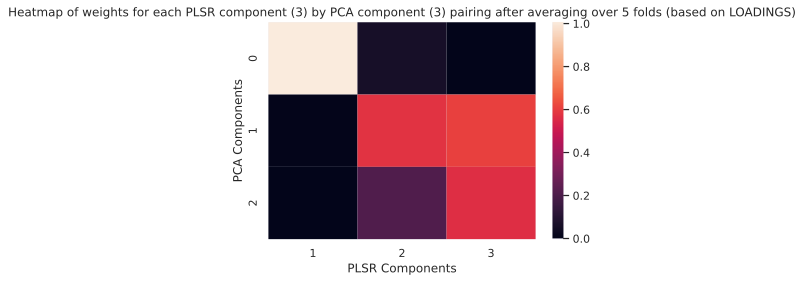

In [ ]:
# We're ready to plot some heatmaps
import seaborn as sns
sns.set()
ax = sns.heatmap(weights_1)
ax.set(title='Heatmap of weights for each PLSR component (3) by PCA component (3) pairing after averaging over 5 folds (based on LOADINGS)', xlabel='PLSR Components', ylabel='PCA Components',
       xticklabels = list(range(1,4)))
plt.show()

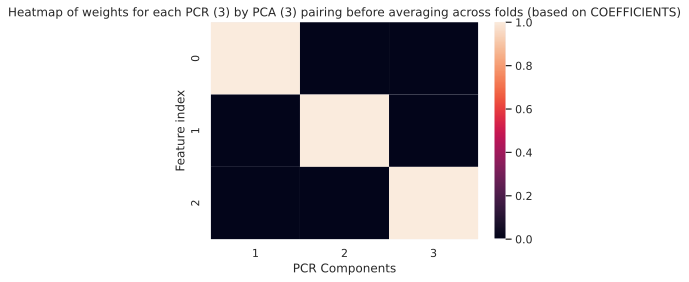

In [ ]:
sns.set()
ax = sns.heatmap(weights_2)
ax.set(title='Heatmap of weights for each PCR (3) by PCA (3) pairing before averaging across folds (based on COEFFICIENTS)', xlabel='PCR Components', ylabel='PCA',
        xticklabels = list(range(1,4)))
plt.show()

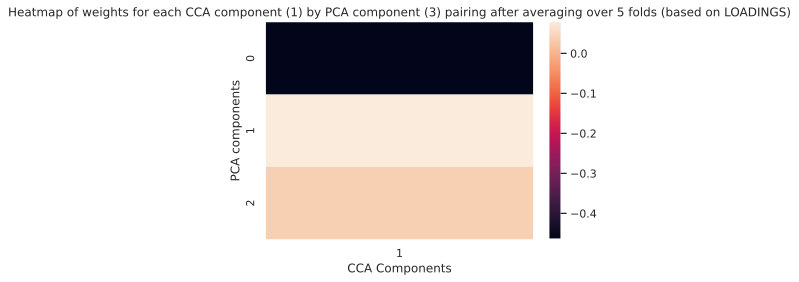

In [ ]:
sns.set()
ax = sns.heatmap(weights_3)
ax.set(title='Heatmap of weights for each CCA component (1) by PCA component (3) pairing after averaging over 5 folds (based on LOADINGS)', xlabel='CCA Components', ylabel='PCA components',
       xticklabels=list(range(1,2)))
plt.show()